# Métodos de Compresión - Breast Cancer Dataset

In [1]:
######################################################################
#	MODEL COMPRESSION TECHNIQUES EXAMPLE. 2022.
######################################################################
# Copyright (C) 2022. J.D.Diaz-Delgado (JDD) jd.diazd@uniandes.edu.co
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, version 3 of the License.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>
####################################################################*/

## Introducción a las Técnicas de Compresión

Las técnicas de compresión son utilizadas para reducir el tamaño de modelos de machine learning con el objetivo de mejorar eficiencia, evitar la sobre-parametrización y optimizar el uso de recursos. Existen diferentes técnicas de compresión, en este caso se usa la poda de parámetros, Knowledge Distillation y la Cuantificación. A continuación se construirá el modelo base y posteriormente se aplicarán estas técnicas para reducir su tamaño.

El modelo que se utiliza en este ejemplo se encarga de realizar una clasificación binaria entre benigno y maligno de la biopsia de una masa en el pecho de un paciente. Se usan 30 características con el fin de determinar si es cancerigeno o no. Este dataset de 569 instancias, con el que se entrenarán y validarán los modelos, le pertenece a la Universidad de Wisconsin y se puede encontrar [aquí](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic))<br>

## Construcción del Modelo Base
En esta sección nos dedicaremos a hacer el preprocesamiento de los datos y a generar el primer modelo del cual partiremos para usar las técnicas de compresión. Empezaremos importando las librerias que usaremos en este ejemplo. La construcción de este modelo base hace parte de un tutorial realizado por Dr. Sreenivas Bhattiprolu que se puede encontrar [aquí](https://colab.research.google.com/drive/1WEZxybgoxQz8Lmp_r6Zq6OHYdvwaz2Df?usp=sharing)<br>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import tensorflow as tf

import tensorflow_model_optimization as tfmot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from sklearn.metrics import confusion_matrix

Se tiene un archivo:

`data.csv`: posee las 30 características de los núcleos de las células tomadas de una biopsia por aspiración con aguja fina sobre cada usuario, identificado con un ID único. Son 10 características principales de las cuales se toma la media (*_mean*), el error estándar (*_se*) y el peor resultado encontrado en la biopsia (*_worst*). Puede observar los nombres de las 10 características principales a continuación:

- ID: número de paciente
- DIAGNOSIS: resultado del diagnóstico; Benigno (B) o Maligno (M)

- RADIUS: distancia desde el centro a puntos en el perímetro
- TEXTURE: textura
- PERIMETER: perimetro
- AREA: área
- SMOOTHNESS: variación local en tamaños del radio
- COMPACTNESS: perimetro^2 / área - 1.0
- CONCAVITY: severidad de las porciones cóncavas del contorno
- CONCAVE_POINTS: número de porciones cóncavas del contorno
- SYMMETRY: simetría
- FRACTAL_DIMENSION: dimensión fractal (aproximación de línea de costa - 1)

A continuación se muestran las primeras instancias del dataset.

In [3]:
df = pd.read_csv("data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Vemos que la columna 32 no tiene ninguna característica asignada y ninguno de los datos de esta columna aporta valor. Por esta razón podemos retirarla y volvemos a imprimir las primeras filas para verificar el cambio.

In [4]:
df.drop('Unnamed: 32', axis=1, inplace=True)

In [5]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Una buena práctica es verificar si hay valores faltantes por cada característica para tomar la decisión de retirar una característica por una gran falta de valores o retirar filas específicas que no cuenten con todos los valores. Podemos verificar esto usando `df.isnull().sum()`

In [6]:
print(df.isnull().sum())

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


En este caso no es necesario eliminar ninguna columna debido a que todas contienen datos. Pasamos ahora a renombrar la columna de `diagnosis` a `label` para tener claro que esta columna contiene el resultado esperado de la clasificación. Adicionalmente, graficaremos la distribución de ambas clases para determinar si hay un desbalance significativo de los datos.

In [7]:
df = df.rename(columns = {'diagnosis' : 'label'})
print(df.dtypes)

id                           int64
label                       object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

Distribución de los datos:  B    357
M    212
Name: label, dtype: int64


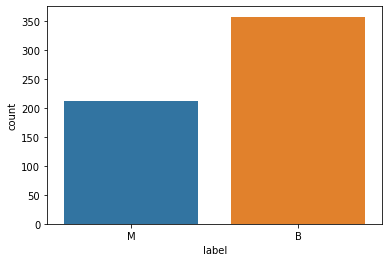

In [8]:
count_plots = sns.countplot(x = "label", data = df)
print("Distribución de los datos: ", df['label'].value_counts())

En la gráfica podemos observar que existe un desbalance entre clases cercano a la razón 4:6. Sin embargo, es un desbalance leve por lo que no es necesario darle un tratamiento diferente. Continuamos con la codificación de etiquetas para hacer el cambio de 'B' y 'M' a 0 y 1, respectivamente. Esto para poder dar un valor a las clases y entrenar el modelo. Para la codificación usamos `LabelEncoder()`. Luego de completada la codificación y de definir `y` como la columna `label`, podemos retirar esta columna y la de `id` (que no aporta nada al entrenamiento) para preparar los datos para el entrenamiento.

In [9]:
y = df['label'].values
print("Las etiquetas antes de la codificación son: ", np.unique(y))

le = LabelEncoder()
Y = le.fit_transform(y)
print("Las etiquetas luego de la codificación son: ", np.unique(Y))

Las etiquetas antes de la codificación son:  ['B' 'M']
Las etiquetas luego de la codificación son:  [0 1]


In [10]:
X = df.drop(labels = ['label', 'id'], axis = 1)
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


En la tabla que acabamos de imprimir vemos que las características toman valores en rangos muy variados: radio entre 17 y 20, perimetro entre 77 y 135, area entre 386 y 1326, etc. Esto hace que sea más dificil el proceso de entrenamiento, por esta razón usaremos la función `MinMaxScaler()` que se encarga de escalar cada característica de forma individual a un rango entre 0 y 1 con el objetivo de obtener un modelo con mejor rendimiento.

In [11]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
print(X)

[[0.52103744 0.0226581  0.54598853 ... 0.91202749 0.59846245 0.41886396]
 [0.64314449 0.27257355 0.61578329 ... 0.63917526 0.23358959 0.22287813]
 [0.60149557 0.3902604  0.59574321 ... 0.83505155 0.40370589 0.21343303]
 ...
 [0.45525108 0.62123774 0.44578813 ... 0.48728522 0.12872068 0.1519087 ]
 [0.64456434 0.66351031 0.66553797 ... 0.91065292 0.49714173 0.45231536]
 [0.03686876 0.50152181 0.02853984 ... 0.         0.25744136 0.10068215]]


Ahora haremos el split de datos de entrenamiento y de validación. Tomaremos el 25% del dataset para validación y el resto para entrenamiento.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)
print("La forma de los datos de entrenamiento es: ", X_train.shape)
print("La forma de los datos de validación es: ", X_test.shape)

La forma de los datos de entrenamiento es:  (426, 30)
La forma de los datos de validación es:  (143, 30)


Ya con la partición de los datos en entrenamiento y validación, podemos crear nuestro modelo de red neuronal. Para este ejemplo usaremos Keras y la armaremos de forma secuencial, lo que significa que añadiremos capa por capa. Tendremos una red neuronal totalmente conectada con 30 neuronas de entrada (para las 30 características), luego una capa oculta de 16 neuronas y por último una neurona de salida. Adicionalmente usamos una capa de `Dropout(0.2)`, entre la capa oculta y la de salida, para que de forma aleatoria el 20% de los pesos se vayan a cero para prevenir un sobreajuste a los datos. Como función de activación se usará una sigmoide. 

Imprimimos el resumen del modelo en el que se muestra cada una de las capas y la cantidad de parámetros.

In [13]:
model = Sequential()
model.add(Dense(16, input_dim = 30, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                496       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
None


2022-12-09 20:48:14.376007: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Luego de haber terminado con el preprocesamiento y de haber escogido una arquitectura para nuestra red neuronal podemos empezar el entrenamiento!! Este proceso lo guardaremos en la variable `history_base` para luego poder analizarlo. Entrenaremos la red por 100 epochs usando un batch size de 64. Si hay problemas de memoria, pueden disminuír el batch size en potenicas de 2.

In [14]:
history_base = model.fit(X_train, y_train, verbose = 1, epochs = 100, batch_size = 64, validation_data = (X_test, y_test))

Epoch 1/100
7/7 [==============================] - 1s 53ms/step - loss: 0.7181 - accuracy: 0.5986 - val_loss: 0.7217 - val_accuracy: 0.6084
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 0.7053 - accuracy: 0.6103 - val_loss: 0.7038 - val_accuracy: 0.6154
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 0.6975 - accuracy: 0.5962 - val_loss: 0.6890 - val_accuracy: 0.6294
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 0.6845 - accuracy: 0.6315 - val_loss: 0.6764 - val_accuracy: 0.6503
Epoch 5/100
7/7 [==============================] - 0s 20ms/step - loss: 0.6703 - accuracy: 0.6573 - val_loss: 0.6639 - val_accuracy: 0.7203
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 0.6618 - accuracy: 0.7066 - val_loss: 0.6507 - val_accuracy: 0.8252
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6501 - accuracy: 0.7441 - val_loss: 0.6371 - val_accuracy: 0.8322
Epoch 8/100
7/7 [====

Finalizado el entrenamiento, podemos analizar el comportamiento de las pérdidas y la precisión a medida que avanzamos de epoch. A continuación podremos ver 2 gráficas relacionadas a estos indicadores.

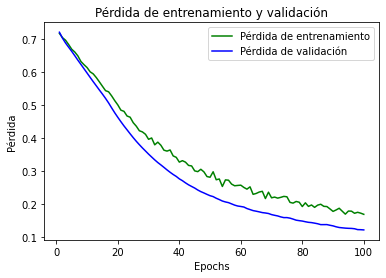

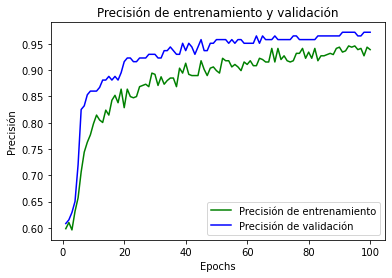

In [16]:
loss = history_base.history['loss']
val_loss = history_base.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.savefig('perdida_modelo_base.png')
plt.show()

acc = history_base.history['accuracy']  # Use accuracy si acc no funciona
val_acc = history_base.history['val_accuracy']  # Use val_accuracy si acc no funciona
plt.plot(epochs, acc, 'g', label='Precisión de entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend()
plt.savefig('precision_modelo_base.png')
plt.show()

Adicionalmente, podemos graficar la matríz de confusión que nos muestra que tan bueno es el modelo prediciendo para ambas clases.

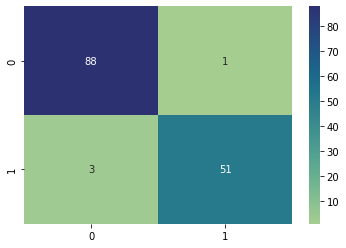

In [17]:
# Predecir los resultados del bloque de validación
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Hacer la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

matriz_modelo_base = sns.heatmap(cm, annot=True, cmap="crest")
fig = matriz_modelo_base.get_figure()
fig.savefig("matriz_modelo_base.png")

## Técnica de Compresión - Poda de parámetros
Ya teniendo nuestro modelo base construido, podemos pasar a aplicar una de las técnicas de compresión para disminuir el tamaño del modelo. Empezaremos con la poda de parámetros. Esta técnica consiste en eliminar de forma iterativa los parámetros con menor peso, es decir, eliminar los parámetros que cuentan con el menor poder predictivo en el modelo. De esta manera, podremos llevar muchos de los pesos a 0 sin que el modelo pierda mucha precisión. En este ejemplo usaremos la librería de `tensorflow_model_optimization`. El uso de esta técnica está basado en el ejemplo de TensorFlow que se puede encontrar [aquí](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras)<br>

Primero haremos un reconteo de los parámetros capa por capa y los imprimiremos para ver sus valores.

In [18]:
count = 0
for element in model.layers[0].get_weights()[0]:
    for i in element:
        # if i != 0: count += 1
        count += 1
for j in model.layers[0].get_weights()[1]:
    # if j != 0: count +=1
    count += 1
    
for element in model.layers[2].get_weights()[0]:
    for i in element:
        count += 1
        
for j in model.layers[2].get_weights()[1]:
    count += 1

print("Total número de parámetros: ", count)
print()

weights = model.get_weights()
print(weights)

Total número de parámetros:  513

[array([[ 0.3416577 , -0.19762318,  0.16598596,  0.13318215,  0.1162674 ,
         0.07249487, -0.12066017,  0.31635892,  0.3977392 , -0.02595372,
        -0.18558253,  0.28164598, -0.04757007,  0.23131901,  0.19627589,
        -0.10330349],
       [ 0.24525744, -0.15210968,  0.02378562,  0.02189753,  0.2553408 ,
         0.10419767,  0.17261516, -0.14824674, -0.3526036 ,  0.15311165,
         0.05785516,  0.07649834,  0.35409126,  0.05875305,  0.05902486,
         0.18221596],
       [ 0.02859715, -0.22727616,  0.13980795, -0.06473144, -0.11966731,
         0.25484636, -0.11827143, -0.25857985,  0.06237007,  0.04916609,
         0.18184283, -0.07094956, -0.26818612, -0.03844782,  0.05497576,
        -0.07673672],
       [-0.2979656 ,  0.41376832, -0.04120276,  0.30276644, -0.22838926,
        -0.33182722, -0.2980643 , -0.2791138 ,  0.11847641,  0.09382918,
         0.03338495,  0.34227696,  0.54245853, -0.15067813,  0.04540022,
        -0.3314905 ],
 

Observamos que tenemos 513 parámetros en total y la gran mayoría de estos pesos es diferente de cero. Ahora guardaremos el modelo base en formato `SavedModel` que es el formato que recomienda TensorFlow en vez de la versión comprimida `.h5`. Para la implementación en FPGA se guardarán los pesos y biases en archivos `.csv`. Es importante eliminar la primera fila y la primera columna de estos archivos para no tener problemas en la implementación.

In [19]:
_, baseline_model_accuracy = model.evaluate(X_test, y_test, verbose = 0)
print('Precisión modelo base:', baseline_model_accuracy)

# Modelo Base - Formato SavedModel
model.save("modelo_base")

# Archivos de Pesos y Biases para implementación en FPGA
w1_base = model.layers[0].get_weights()[0]
b1_base = model.layers[0].get_weights()[1]
w2_base = model.layers[2].get_weights()[0]
b2_base = model.layers[2].get_weights()[1]

pd.DataFrame(w1_base).to_csv("w1_base.csv")
pd.DataFrame(b1_base).to_csv("b1_base.csv")
pd.DataFrame(w2_base).to_csv("w2_base.csv")
pd.DataFrame(b2_base).to_csv("b2_base.csv")

Precisión modelo base: 0.9720279574394226


2022-12-09 22:35:07.748669: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: modelo_base/assets


Adicionalmente, haremos la conversión de este modelo a TensorFlowLite para hacer la implementación en el microcontrolador. No se usará optimización en el proceso de conversión para poder compararlo posteriormente con los modelos cuantificados.

In [36]:
# Conversión del modelo
converter = tf.lite.TFLiteConverter.from_saved_model("modelo_base")
tflite_model = converter.convert()
open("modelo_base.tflite", "wb").write(tflite_model)

2022-12-10 00:30:07.945611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-12-10 00:30:07.945700: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-12-10 00:30:07.945708: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2022-12-10 00:30:07.978266: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: modelo_base
2022-12-10 00:30:07.998336: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-12-10 00:30:07.998367: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: modelo_base
2022-12-10 00:30:08.023377: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-12-10 00:30:08.163118: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: modelo_base
2022-12-10 00:30:

3504

Ahora usaremos parte del ejemplo dado por TensorFlow para crear el modelo que vamos a podar con sus respectivos parámetros de poda. En este caso vamos a entrenar el modelo por la misma cantidad de epochs (100), mismo batch size (64) y mismo porcentaje para bloque de validación (25%) que el modelo base. Adicionalmente, iniciaremos con un sparsity del 30% y finalizaremos con un sparsity del 60%. Esto quiere decir que se removerá luego de la primera iteración el 30% de los parámetros y se seguirán removiendo iterativamente hasta llegar al 60% en el último epoch. Como salida de este bloque de código tenemos un resumen del modelo que usaremos para podar.

In [20]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Calcule el paso final para finalizar la poda luego de 100 epochs.
batch_size = 64
epochs = 100
validation_split = 0.25 # 25% de los datos se usará para validación. 

X_num = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(X_num / batch_size).astype(np.int32) * epochs

# Defina el modelo para podar.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.60,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requiere una recompilación.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense (  (None, 16)               978       
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_dropout  (None, 16)               1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_1  (None, 1)                35        
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_activat  (None, 1)                1         
 ion (PruneLowMagnitude)                                         
                                                                 
Total params: 1,015
Trainable params: 513
Non-trainable 

Ahora pasamos a entrenar el modelo para podar!

In [21]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir = logdir),
]

history_poda = model_for_pruning.fit(X_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/100
5/5 [==============================] - 3s 52ms/step - loss: 0.1655 - accuracy: 0.9436 - val_loss: 0.1612 - val_accuracy: 0.9439
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 0.1605 - accuracy: 0.9373 - val_loss: 0.1625 - val_accuracy: 0.9252
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 0.1577 - accuracy: 0.9530 - val_loss: 0.1630 - val_accuracy: 0.9252
Epoch 4/100
5/5 [==============================] - 0s 14ms/step - loss: 0.1605 - accuracy: 0.9436 - val_loss: 0.1616 - val_accuracy: 0.9252
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 0.1561 - accuracy: 0.9655 - val_loss: 0.1610 - val_accuracy: 0.9252
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 0.1555 - accuracy: 0.9404 - val_loss: 0.1607 - val_accuracy: 0.9252
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 0.1609 - accuracy: 0.9498 - val_loss: 0.1606 - val_accuracy: 0.9252
Epoch 8/100
5/5 [===

Luego de entrenar este modelo, podemos pasar a analizarlo con las mismas gráficas que mostramos para el modelo base y mostrando la matriz de confusión.

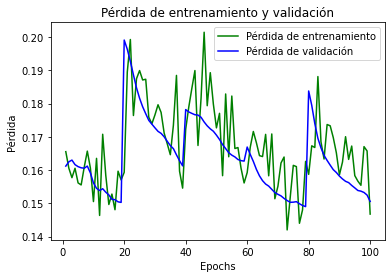

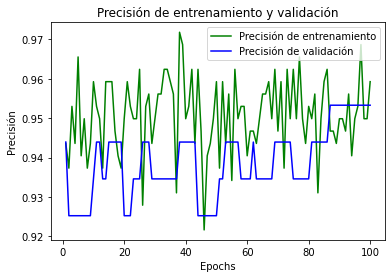

In [22]:
loss = history_poda.history['loss']
val_loss = history_poda.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.savefig('perdida_modelo_podado.png')
plt.show()

acc = history_poda.history['accuracy']  # Use accuracy si acc no funciona
val_acc = history_poda.history['val_accuracy']  # Use val_accuracy si acc no funciona
plt.plot(epochs, acc, 'g', label='Precisión de entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend()
plt.savefig('precision_modelo_podado.png')
plt.show()

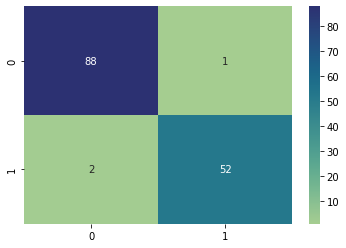

In [23]:
# Predecir los resultados del bloque de validación
y_pred_poda = model_for_pruning.predict(X_test)
y_pred_poda = (y_pred_poda > 0.5)

# Hacer la matriz de confusión
cm_poda = confusion_matrix(y_test, y_pred_poda)

matriz_poda = sns.heatmap(cm_poda, annot=True, cmap="crest")
fig = matriz_poda.get_figure()
fig.savefig("matriz_modelo_podado.png")

Observamos que durante el proceso de entrenamiento, cerca al epoch 20, 40, 60 y 80 hay una pérdida en precisión y un aumento en pérdida significativo. Esto se da porque en estos epochs se removió un parámetro con un poder predictivo considerable. Sin embargo, el modelo aprende a predecir con los parámetros que le quedan y recupera su precisión rápidamente. En la matriz de confusión vemos que el comportamiento es muy similar al modelo base, por lo que no hay una pérdida en desempeño significativa.

In [24]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   X_test, y_test, verbose=0)

print('Precisión del modelo base:', baseline_model_accuracy)
print('Precisión del modelo podado:', model_for_pruning_accuracy)

Precisión del modelo base: 0.9720279574394226
Precisión del modelo podado: 0.9790209531784058


Vemos que al evaluar el modelo con el set de validación, no hay impacto en la precisión respecto al modelo base. Esto nos muestra que la poda de parámetros ha sido muy efectiva y vale la pena hacer uso de este modelo comprimido. A continuación haremos un conteo de los parámetros de la red diferentes a cero para ver cuál fue el impacto de la compresión.

In [25]:
count = 0
for element in model_for_pruning.layers[0].get_weights()[0]:
    for i in element:
        if i != 0: count += 1
for j in model_for_pruning.layers[0].get_weights()[1]:
    if j != 0: count +=1
    
for element in model_for_pruning.layers[2].get_weights()[0]:
    for i in element:
        if i != 0: count += 1
        
for j in model_for_pruning.layers[2].get_weights()[1]:
    if j != 0: count += 1

print("Total número de parámetros: ", count)
print()

weights = model_for_pruning.get_weights()
print(weights)

Total número de parámetros:  214

[array([[ 0.35629463,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.        ,  0.        ,  0.3370018 ,  0.41427842, -0.        ,
        -0.        ,  0.26830062,  0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        ,  0.        , -0.        ,  0.        , -0.        ,
        -0.        ,  0.        , -0.        , -0.36321244,  0.25325423,
         0.        ,  0.        ,  0.44944933, -0.        , -0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.22248699,  0.        , -0.241909  ,  0.        ,  0.        ,
         0.        , -0.        , -0.23654217, -0.        , -0.        ,
        -0.        ],
       [-0.29439187,  0.4574218 , -0.        ,  0.45052138, -0.        ,
        -0.42757156, -0.29788017, -0.28277028, -0.        ,  0.        ,
         0.        ,  0.3440553 ,  0.6536286 , -0.        , -0.        ,
        -0.3314905 ],
 

Vemos que el número de parámetros diferentes a cero se redujo drásticamente. Esto se puede evidenciar en el conteo de parámetros y visualmente al imprimir los pesos del modelo podado. Ahora guardaremos el modelo base en formato `SavedModel` que es el formato que recomienda TensorFlow en vez de la versión comprimida `.h5`. Para la implementación en FPGA se guardarán los pesos y biases en archivos `.csv`. Es importante eliminar la primera fila y la primera columna de estos archivos para no tener problemas en la implementación.

In [30]:
# Modelo Podado - Formato SavedModel
model_for_pruning.save("modelo_podado")

# Archivos de Pesos y Biases para implementación en FPGA
w1_podado = model_for_pruning.layers[0].get_weights()[0]
b1_podado = model_for_pruning.layers[0].get_weights()[1]
w2_podado = model_for_pruning.layers[2].get_weights()[0]
b2_podado = model_for_pruning.layers[2].get_weights()[1]

pd.DataFrame(w1_podado).to_csv("w1_podado.csv")
pd.DataFrame(b1_podado).to_csv("b1_podado.csv")
pd.DataFrame(w2_podado).to_csv("w2_podado.csv")
pd.DataFrame(b2_podado).to_csv("b2_podado.csv")

INFO:tensorflow:Assets written to: modelo_podado/assets


INFO:tensorflow:Assets written to: modelo_podado/assets


Adicionalmente, haremos la conversión de este modelo a TensorFlowLite para hacer la implementación en el microcontrolador. No se usará optimización en el proceso de conversión para poder compararlo posteriormente con los modelos cuantificados. Debido a que el modelo podado no quedó bien guardado porque contaba con parámetros basura que se incluyeron durante el proceso de poda, se genera a continuación otro modelo con la misma arquitectura y se le cargan los parámetros relevantes para poder hacer la conversión del modelo correctamente. El modelo arreglado quedará guardado en la carpeta `modelo_podado_fix`.

In [65]:
modelo_podado_fix = keras.Sequential()
modelo_podado_fix.add(keras.layers.Dense(16, input_dim = 30, activation = 'relu', trainable=False))
modelo_podado_fix.add(keras.layers.Dropout(0.2))
modelo_podado_fix.add(keras.layers.Dense(1, trainable=False))
modelo_podado_fix.add(keras.layers.Activation('sigmoid'))

modelo_podado_fix.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

modelo_podado_fix.layers[0].set_weights(model_for_pruning.layers[0].get_weights())
modelo_podado_fix.layers[2].set_weights(model_for_pruning.layers[2].get_weights())

# Modelo Podado Arreglado - Formato SavedModel
modelo_podado_fix.save("modelo_podado_fix")

# Conversión del modelo
converter = tf.lite.TFLiteConverter.from_saved_model("modelo_podado_fix")
tflite_model = converter.convert()
open("modelo_podado.tflite", "wb").write(tflite_model)

# print(modelo_podado_fix.summary())

INFO:tensorflow:Assets written to: modelo_podado_fix/assets


INFO:tensorflow:Assets written to: modelo_podado_fix/assets
2022-12-10 01:15:05.407090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-12-10 01:15:05.407113: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-12-10 01:15:05.407118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2022-12-10 01:15:05.407495: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: modelo_podado_fix
2022-12-10 01:15:05.408957: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-12-10 01:15:05.408977: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: modelo_podado_fix
2022-12-10 01:15:05.414436: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-12-10 01:15:05.446145: I tensorflow/cc/saved_model/loader.cc:194] Running initi

3552

## Técnicas de Compresión - Knowledge Distillation

Esta técnica de compresión fue propuesta por Google en el 2015 y consiste en entrenar una red neuronal profesora para luego transferirle el conocimiento a una red neuronal estudiante que tiene un menor tamaño. Este método se basa en la idea de que es posible comprimir el conocimiento y reducir drásticamente el tamaño de los modelos sin comprometer la capacidad de predicción. Los resultados obtenidos por Google fueron usando el dataset de MNIST. En este caso, trataremos de comprimir el conocimiento de nuestro modelo base y mantener una buena precisión. Iniciaremos definiendo la clase `Distiller()` que modifica las funciones `train_step`, `test_step` y `compile()`. El tutorial de esta técnica está basado en la implementación de Kenneth Borup. Por lo tanto, el uso de esta clase y de la técnica en general está detallado allí. 

La implementación de Kenneth Borup se puede encontrar [aquí](https://keras.io/examples/vision/knowledge_distillation/)<br>

In [31]:
from tensorflow import keras
from tensorflow.keras import layers

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

Luego de haber definido la clase `Distiller()`, pasamos a crear los modelos estudiante y profesor. Estos modelos son creados usando `Sequential()`. Inicialmente vamos a definir la red profesora con 16 neuronas en la capa oculta (como en el modelo base) y la red estudiante con 5 neuronas en la capa oculta.

In [32]:
capa_oculta_profesora = 16 # Cantidad de neuronas en la capa oculta de la red profesora
capa_oculta_estudiante = 5 # Cantidad de neuronas en la capa oculta de la red estudiante

# Crear red profesora
teacher = keras.Sequential(name = "teacher")
teacher.add(keras.layers.Dense(capa_oculta_profesora, input_dim = 30, activation = 'relu'))
teacher.add(keras.layers.Dropout(0.2))
teacher.add(keras.layers.Dense(1))
teacher.add(keras.layers.Activation('sigmoid'))

# Crear red estudiante
student = keras.Sequential(name = "student")
student.add(keras.layers.Dense(capa_oculta_estudiante, input_dim = 30, activation = 'relu'))
student.add(keras.layers.Dropout(0.2))
student.add(keras.layers.Dense(1))
student.add(keras.layers.Activation('sigmoid'))

# Clonar red estudiante para comparación posterior
student_scratch = keras.models.clone_model(student)

Ya definidos los dos modelos, podemos pasar al entrenamiento de la red profesora.

In [33]:
teacher.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print(teacher.summary())

teacher.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_data = (X_test, y_test))
teacher.evaluate(X_test, y_test)

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                496       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
7/7 [==============================] - 1s 28ms/step - loss: 0.6971 - accuracy: 0.5211 - val_loss: 0.6791 - val_accuracy: 0.6154
Epoch 2/100
7/7 [==============================]

[0.13257083296775818, 0.9650349617004395]

Ahora pasamos a destilar el conocimiento de la red profeosra a la red estudiante.

In [34]:
# Initialize and compile distiller

distiller = Distiller(student=student, teacher=teacher)
# distiller.compile(
#     optimizer=keras.optimizers.Adam(),
#     metrics=[keras.metrics.Accuracy()],
#     student_loss_fn=keras.losses.BinaryCrossentropy(),
#     distillation_loss_fn=keras.losses.KLDivergence(),
#     alpha=0.1,
#     temperature=10,
# )

distiller.compile(optimizer = 'adam', metrics = ['accuracy'], student_loss_fn = keras.losses.BinaryCrossentropy(), distillation_loss_fn = keras.losses.BinaryCrossentropy(), alpha = 0.1, temperature = 10)

# Distill teacher to student
distiller.fit(X_train, y_train, epochs=100, batch_size = 64, validation_data = (X_test, y_test))

# Evaluate student on test dataset
distiller.evaluate(X_test, y_test)

# weights = distiller.get_weights()
# print(weights)
# print(student.summary())

# model.save("distilled_model.h5")

Epoch 1/100
7/7 [==============================] - 1s 26ms/step - accuracy: 0.6620 - student_loss: 0.6643 - distillation_loss: 0.0000e+00 - val_accuracy: 0.6294 - val_student_loss: 0.6613
Epoch 2/100
7/7 [==============================] - 0s 15ms/step - accuracy: 0.6502 - student_loss: 0.6638 - distillation_loss: 0.0000e+00 - val_accuracy: 0.6713 - val_student_loss: 0.6485
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - accuracy: 0.6737 - student_loss: 0.6413 - distillation_loss: 0.0000e+00 - val_accuracy: 0.7273 - val_student_loss: 0.6368
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - accuracy: 0.7230 - student_loss: 0.6396 - distillation_loss: 0.0000e+00 - val_accuracy: 0.7902 - val_student_loss: 0.6262
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - accuracy: 0.7277 - student_loss: 0.6328 - distillation_loss: 0.0000e+00 - val_accuracy: 0.8182 - val_student_loss: 0.6163
Epoch 6/100
7/7 [==============================] - 0s 12ms/s

[0.9510489702224731, 0.21359868347644806]

Ahora vamos a entrenar la red estudiante por separado para ver qué beneficios trae usar knowledge distillation en este caso.

In [35]:
student_scratch.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

student_scratch.fit(X_train, y_train, epochs=100, batch_size = 64, validation_data = (X_test, y_test))
student_scratch.evaluate(X_test, y_test)

Epoch 1/100
7/7 [==============================] - 1s 27ms/step - loss: 0.7230 - accuracy: 0.5235 - val_loss: 0.7258 - val_accuracy: 0.5385
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.7161 - accuracy: 0.5634 - val_loss: 0.7177 - val_accuracy: 0.5664
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.7033 - accuracy: 0.6033 - val_loss: 0.7095 - val_accuracy: 0.5944
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 0.7032 - accuracy: 0.5915 - val_loss: 0.7009 - val_accuracy: 0.6014
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 0.6949 - accuracy: 0.6315 - val_loss: 0.6922 - val_accuracy: 0.6224
Epoch 6/100
7/7 [==============================] - 0s 20ms/step - loss: 0.6821 - accuracy: 0.6432 - val_loss: 0.6833 - val_accuracy: 0.6224
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6744 - accuracy: 0.6620 - val_loss: 0.6755 - val_accuracy: 0.6224
Epoch 8/100
7/7 [=======

[0.17614877223968506, 0.9650349617004395]

Luego de aplicar la técnica de compresión de Knowledge Distillation se evidencia que el conocimiento se transmite de forma satisfactoria de la red profesora a la red estudiante perdiendo únicamente un punto de precisión. Sin embargo, al entrenar la red estudiante directamente observamos que se obtiene una precisión mucho más cercana a la de la red profesora. Esto quiere decir que a pesar que la transferencia de conocimiento de una red a otra es posible, pero no es eficiente en este caso. Por lo tanto, descartaremos esta técnica de compresión debido a que no está aportando valor a este modelo.

## Técnicas de Compresión - Cuantización

Por último, vamos a revisar la cuantización de los modelos como técnica de compresión. Esta técnica consiste en cambiar la representación de los pesos, biases y/o entradas con el fin de simplificar las operaciones que se realizan en el proceso de inferencia o para disminuir el tamaño de los modelos al disminuir la cantidad de bits con los que se representan estos números. Normalmente, la cuantización viene acompañada de pérdidas en precisión y es precisamente lo que se va a evaluar en este ejemplo. Acá se hará la conversión a modelos de TFLite con cuantización a Float16 (fp16) y de rango dinámico (drq) y se va a evaluar su desempeño en el microcontrolador.

In [75]:
# Conversión del modelo - Cuantización con Float16
converter = tf.lite.TFLiteConverter.from_saved_model("modelo_base")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open("modelo_cuantizado_fp16.tflite", "wb").write(tflite_model)

# Conversión del modelo - Cuantización con Dynamic Range
converter = tf.lite.TFLiteConverter.from_saved_model("modelo_base")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("modelo_cuantizado_drq.tflite", "wb").write(tflite_model)

2022-12-10 03:01:21.641367: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-12-10 03:01:21.641382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-12-10 03:01:21.641403: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2022-12-10 03:01:21.641528: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: modelo_base
2022-12-10 03:01:21.643792: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-12-10 03:01:21.643807: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: modelo_base
2022-12-10 03:01:21.652654: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-12-10 03:01:21.697952: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: modelo_base
2022-12-10 03:01:

3600

Para la validación de los modelos en el microcontrolador y la generación del Testbench en la FPGA es necesario generar archivos `.csv` que contengan los datos de validación. A continuación se generan.

In [ ]:
pd.DataFrame(X_test).to_csv('x_test.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')